In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertModel, BertTokenizer
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm
import datetime

from transformers.optimization import get_linear_schedule_with_warmup
from torch.optim import AdamW

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

# Define paths for dataset in Google Drive
train_path = "/content/drive/MyDrive/archive/test.csv"
test_path = "/content/drive/MyDrive/archive/train.csv"

# Load train and test data
train_data = pd.read_csv(train_path, encoding='ISO-8859-1')
test_data = pd.read_csv(test_path, encoding='ISO-8859-1')

# Display the first few rows to check the structure
print("First few rows of the training data:")
print(train_data.head())

print("\nFirst few rows of the test data:")
print(test_data.head())

# Display the columns of each dataset to check their structure
print("\nColumns in the training data:", train_data.columns)
print("Columns in the test data:", test_data.columns)

# Check for unique values in the sentiment column
print("\nUnique values in the training sentiment column:", train_data['sentiment'].unique())
print("Unique values in the test sentiment column:", test_data['sentiment'].unique())

# Handle missing values
train_data['sentiment'].fillna(" ", inplace=True)
train_data['text'].fillna(" ", inplace=True)

test_data['sentiment'].fillna(" ", inplace=True)
test_data['text'].fillna(" ", inplace=True)

# Remove rows with invalid sentiment values
valid_sentiments = ['positive', 'negative', 'neutral']
train_data = train_data[train_data['sentiment'].isin(valid_sentiments)]
test_data = test_data[test_data['sentiment'].isin(valid_sentiments)]

# Encode labels
le = LabelEncoder()
train_data['labels'] = le.fit_transform(train_data['sentiment'])
test_data['labels'] = le.transform(test_data['sentiment'])

# Drop unnecessary columns
train_data = train_data[['text', 'labels']]
test_data = test_data[['text', 'labels']]

# Print the first few rows to check the structure after preprocessing
print("Preprocessed training data:")
print(train_data.head())

print("Preprocessed test data:")
print(test_data.head())

# One-hot encode labels
one_hot = OneHotEncoder()
train_data_labels = one_hot.fit_transform(train_data[['labels']].values.reshape(-1, 1)).toarray()
test_data_labels = one_hot.transform(test_data[['labels']].values.reshape(-1, 1)).toarray()

train_data = train_data.drop(columns=['labels'])
test_data = test_data.drop(columns=['labels'])

# Add one-hot encoded labels to train and test data
train_data['labels'] = train_data_labels.tolist()
test_data['labels'] = test_data_labels.tolist()

# Print the first few rows of the training data to check the structure after encoding
print("Training data sample after one-hot encoding:")
print(train_data.head())

print("Test data sample after one-hot encoding:")
print(test_data.head())


First few rows of the training data:
       textID                                               text sentiment  \
0  f87dea47db  Last session of the day  http://twitpic.com/67ezh   neutral   
1  96d74cb729   Shanghai is also really exciting (precisely -...  positive   
2  eee518ae67  Recession hit Veronique Branquinho, she has to...  negative   
3  01082688c6                                        happy bday!  positive   
4  33987a8ee5             http://twitpic.com/4w75p - I like it!!  positive   

  Time of Tweet Age of User      Country  Population -2020  Land Area (Km²)  \
0       morning        0-20  Afghanistan        38928346.0         652860.0   
1          noon       21-30      Albania         2877797.0          27400.0   
2         night       31-45      Algeria        43851044.0        2381740.0   
3       morning       46-60      Andorra           77265.0            470.0   
4          noon       60-70       Angola        32866272.0        1246700.0   

   Density (P/Km²) 

<ipython-input-3-be039a39efd5>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['labels'] = le.fit_transform(train_data['sentiment'])


=== Running on GPU ===


Epoch 1/10: 100%|██████████| 111/111 [02:27<00:00,  1.33s/it, loss=0.768, lr=0.0009]


Epoch: 1, Loss: 0.7601


Epoch 2/10: 100%|██████████| 111/111 [02:30<00:00,  1.36s/it, loss=0.737, lr=0.0008]


Epoch: 2, Loss: 0.7578


Epoch 3/10: 100%|██████████| 111/111 [02:30<00:00,  1.35s/it, loss=0.759, lr=0.0007]


Epoch: 3, Loss: 0.7575


Epoch 4/10: 100%|██████████| 111/111 [02:30<00:00,  1.35s/it, loss=0.756, lr=0.0006]


Epoch: 4, Loss: 0.7572


Epoch 5/10: 100%|██████████| 111/111 [02:30<00:00,  1.35s/it, loss=0.754, lr=0.0005]


Epoch: 5, Loss: 0.7573


Epoch 6/10: 100%|██████████| 111/111 [02:30<00:00,  1.35s/it, loss=0.731, lr=0.0004]


Epoch: 6, Loss: 0.7569


Epoch 7/10: 100%|██████████| 111/111 [02:30<00:00,  1.36s/it, loss=0.754, lr=0.0003]


Epoch: 7, Loss: 0.7571


Epoch 8/10: 100%|██████████| 111/111 [02:30<00:00,  1.35s/it, loss=0.758, lr=0.0002]


Epoch: 8, Loss: 0.7571


Epoch 9/10: 100%|██████████| 111/111 [02:30<00:00,  1.35s/it, loss=0.772, lr=0.0001]


Epoch: 9, Loss: 0.7571


Epoch 10/10: 100%|██████████| 111/111 [02:30<00:00,  1.36s/it, loss=0.754, lr=0]


Epoch: 10, Loss: 0.7570


Test: 100%|██████████| 859/859 [06:34<00:00,  2.18it/s, loss=0.776]


Model saved


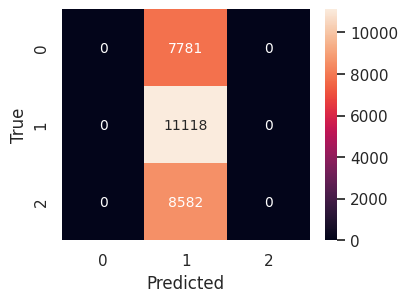

              precision    recall  f1-score   support

      class0       0.00      0.00      0.00      7781
      class1       0.40      1.00      0.58     11118
      class2       0.00      0.00      0.00      8582

    accuracy                           0.40     27481
   macro avg       0.13      0.33      0.19     27481
weighted avg       0.16      0.40      0.23     27481



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Menentukan kelas TextDataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

# Menentukan kelas CustomBERTClassifier
class CustomBERTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CustomBERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.fc1 = nn.Linear(self.bert.config.hidden_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = bert_outputs["last_hidden_state"][:, 0, :]
        x = self.fc1(cls_output)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# inisialisai model dan tokenizer
model = CustomBERTClassifier(num_classes=3)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Mengecheck GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type != "cuda":
    print("=== GPU not found, running on CPU ===")
else:
    print("=== Running on GPU ===")

# Membuat datasets dan dataloaders
train_texts = train_data['text'].tolist()
test_texts = test_data['text'].tolist()
train_labels = train_data['labels'].tolist()
test_labels = test_data['labels'].tolist()

max_length = 256

train_dataset = TextDataset(train_texts, train_labels, tokenizer, max_length)
test_dataset = TextDataset(test_texts, test_labels, tokenizer, max_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Menentukan optimizer and learning rate scheduler
learning_rate = 1e-3
optimizer = AdamW(model.parameters(), lr=learning_rate)  # Define optimizer here

num_epochs = 10  # Define num_epochs before using it

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_epochs*len(train_loader))

criterion = nn.BCEWithLogitsLoss()

# Move model to the appropriate device (GPU/CPU)
model.to(device)

# Menentukan training function dengam learning rate scheduling
def train_model(model, epoch, num_epochs, train_dataloader, optimizer, scheduler, criterion, device):
    model.train()
    total_loss = 0
    loop = tqdm(enumerate(train_dataloader), total=len(train_dataloader), leave=True)
    for batch_idx, batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        loop.set_description(f"Epoch {epoch+1}/{num_epochs}")
        loop.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])  # Display current learning rate

    avg_loss = total_loss / len(train_dataloader)
    return avg_loss

# Define testing function
def test_model(model, test_dataloader, criterion, device):
    model.eval()
    total_loss = 0
    loop = tqdm(enumerate(test_dataloader), total=len(test_dataloader), leave=True)
    for batch_idx, batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            loop.set_description(f"Test")
            loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(test_dataloader)
    return avg_loss

# Training loop dengan jadwal learning rate
for epoch in range(num_epochs):
    loss = train_model(model, epoch, num_epochs, train_loader, optimizer, scheduler, criterion, device)
    print(f"Epoch: {epoch+1}, Loss: {loss:.4f}")

# Evaluation
test_loss = test_model(model, test_loader, criterion, device)
if test_loss < 1.0:
    date_time = datetime.datetime.now().strftime("%Y-%m-%d_%H%M")
    file_name = f"model_checkpoint_{date_time}_loss{test_loss:.3f}.pth"
    torch.save({
        'epoch': num_epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': test_loss,
    }, file_name)
    print('Model saved')

# Menentukan fungsi prediksi
def get_predictions(model, data_loader):
    model.eval()
    predictions = []
    real_values = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            outputs = torch.sigmoid(outputs)

            predictions.append(outputs)
            real_values.append(labels)

    predictions = torch.cat(predictions).cpu()
    real_values = torch.cat(real_values).cpu()
    return predictions, real_values

# Membuat prediksi dan evaluasi
y_pred, y_test = get_predictions(model, test_loader)

# Konversi prediksi ke  format one-hot encoded
y_pred = torch.argmax(y_pred, dim=1).numpy()

# Konversi real values ke format one-hot encoded
y_test = torch.argmax(torch.tensor(test_labels), dim=1).numpy()

# Generate dan plot confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.set(font_scale=1)
sns.heatmap(conf_mat, annot=True, annot_kws={"size": 10}, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# cetak classification report
print(classification_report(y_test, y_pred, target_names=['class0', 'class1', 'class2']))
